In [51]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # OpenCV for image processing
from PIL import Image  # PIL for image handling
import tensorflow as tf
import os
from glob import glob
import nibabel as nib  # For reading .nii files (MRI format)

# Check TensorFlow version
print("TensorFlow Version:", tf.__version__)

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow Version: 2.19.0


## Loading Dataset

In [52]:
# Define dataset path
#data_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/'

data_path = 'kaggle_3m/'


# Get list of all image and mask files separately
image_files = sorted([f for f in glob(os.path.join(data_path, '*', '*tif')) if '_mask' not in f])
mask_files = sorted([f for f in glob(os.path.join(data_path, '*', '*tif')) if '_mask' in f])


print("Number of image files:", len(image_files))
print("Number of mask files:", len(mask_files))
print("Sample image path:", image_files[0])
print("Sample mask path:", mask_files[0])

Number of image files: 3929
Number of mask files: 3929
Sample image path: kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_1.tif
Sample mask path: kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10_mask.tif


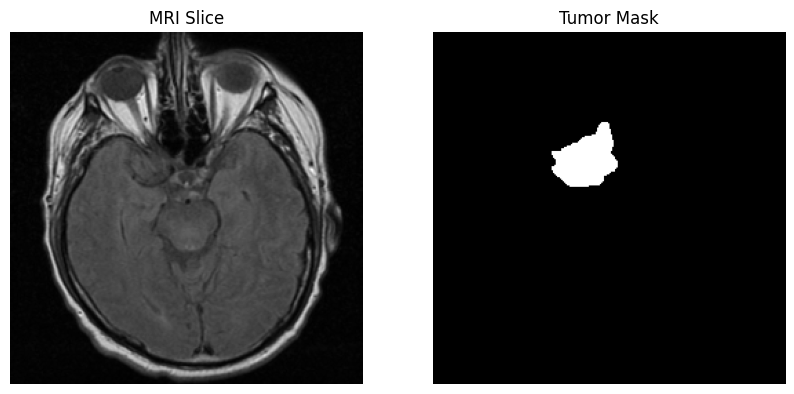

In [53]:
# Load sample image and mask
sample_img = Image.open(image_files[1]).convert('L')  # Convert to grayscale
sample_mask = Image.open(mask_files[1]).convert('L')  # Convert to grayscale

# Convert to numpy arrays for display
sample_img_np = np.array(sample_img)
sample_mask_np = np.array(sample_mask)

# Visualize
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_img_np, cmap='gray')
plt.title('MRI Slice')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_mask_np, cmap='gray')
plt.title('Tumor Mask')
plt.axis('off')

plt.show()

In [54]:
# Verify pairing
for img, mask in zip(image_files[:5], mask_files[:5]):
    print(f"Image: {os.path.basename(img)}, Mask: {os.path.basename(mask)}")

Image: TCGA_CS_4941_19960909_1.tif, Mask: TCGA_CS_4941_19960909_10_mask.tif
Image: TCGA_CS_4941_19960909_10.tif, Mask: TCGA_CS_4941_19960909_11_mask.tif
Image: TCGA_CS_4941_19960909_11.tif, Mask: TCGA_CS_4941_19960909_12_mask.tif
Image: TCGA_CS_4941_19960909_12.tif, Mask: TCGA_CS_4941_19960909_13_mask.tif
Image: TCGA_CS_4941_19960909_13.tif, Mask: TCGA_CS_4941_19960909_14_mask.tif


## Visualizing Data

In [55]:
# Initialize counters
tumor_count = 0
non_tumor_count = 0

# Check each mask for tumor presence
for img_path, mask_path in zip(image_files, mask_files):
    mask = np.array(Image.open(mask_path).convert('L'))
    if np.any(mask > 0):
        tumor_count += 1
    else:
        non_tumor_count += 1

print(f"Number of tumor images: {tumor_count}")
print(f"Number of non-tumor images: {non_tumor_count}")
print(f"Total images: {tumor_count + non_tumor_count}")

Number of tumor images: 1373
Number of non-tumor images: 2556
Total images: 3929


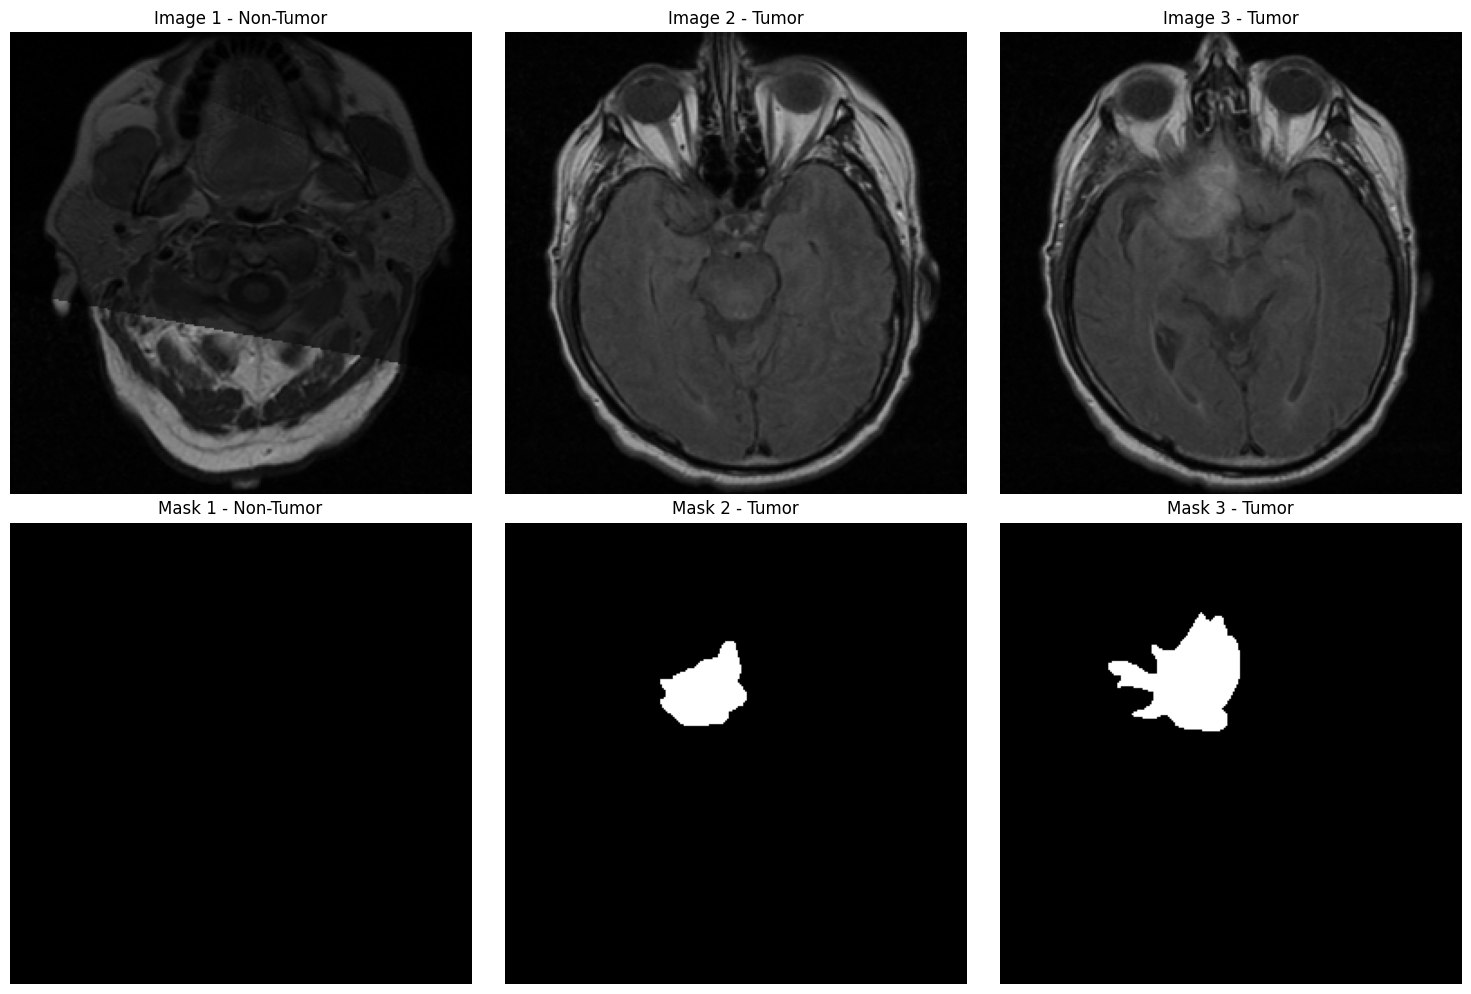

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from glob import glob


# Function to check tumor presence and display image with mask
def display_sample_images(num_samples=3):
    plt.figure(figsize=(15, 5 * (num_samples // 3 + 1)))
    
    for i in range(min(num_samples, len(image_files))):
        # Load image and mask
        img_path = image_files[i]
        mask_path = mask_files[i]
        try:
            img = np.array(Image.open(img_path).convert('L'))  # Convert to grayscale
            mask = np.array(Image.open(mask_path).convert('L'))  # Convert to grayscale
            
            # Debugging: Print image and mask shapes and min/max values
            # print(f"Image {i+1} - Path: {img_path}")
            # print(f"Shape: {img.shape}, Min: {img.min()}, Max: {img.max()}")
            # print(f"Mask {i+1} - Path: {mask_path}")
            # print(f"Shape: {mask.shape}, Min: {mask.min()}, Max: {mask.max()}")
            
            # Check for tumor presence
            has_tumor = np.any(mask > 0)
            label = "Tumor" if has_tumor else "Non-Tumor"
            
            # Create subplots
            plt.subplot(num_samples // 3 + 1, 3, i + 1)
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            plt.title(f'Image {i+1} - {label}')
            plt.axis('off')
            
            plt.subplot(num_samples // 3 + 1, 3, i + 1 + num_samples)
            plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
            plt.title(f'Mask {i+1} - {label}')
            plt.axis('off')
        
        except Exception as e:
            print(f"Error loading image/mask {i+1}: {e}")
    
    plt.tight_layout()
    plt.show()

# Display 3 sample images and their masks
display_sample_images(num_samples=3)

## Understanding Data Distribution

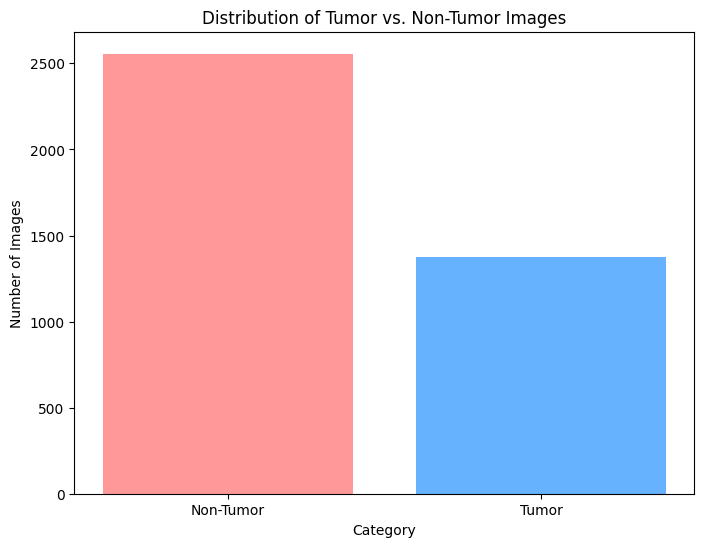

In [57]:
# Data for the graph
labels = ['Non-Tumor', 'Tumor']
counts = [non_tumor_count, tumor_count]
colors = ['#FF9999', '#66B2FF']  # Light red for non-tumor, light blue for tumor

# Create bar graph
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=colors)
plt.title('Distribution of Tumor vs. Non-Tumor Images')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()

## Preprocessing Data

### - Resize all images and masks to a uniform size (e.g., 256x256) to match input requirements for deep learning models.
### - Normalize image pixel values (e.g., scale to [0, 1] or standardize) for better model training.
### - Since there are more non-tumor images, we’ll augment the tumor images to balance the dataset. Augmentation techniques include rotation, flipping, zooming, and brightness adjustment.
### - Create a dataset structure with labels for classification (tumor vs. non-tumor) and image-mask pairs for segmentation.
### - Split the data into training, validation, and test sets.

In [58]:

IMG_SIZE = (224, 224)  # Resize to 224x224 for transfer learning
NUM_CLASSES = 1  # Binary classification (tumor vs. non-tumor)

# Load and preprocess images and masks
def preprocess_data(image_paths, mask_paths):
    images = []
    masks = []
    labels = []
    
    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0  # Normalize to [0, 1]
        
        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, IMG_SIZE)
        mask = mask / 255.0  # Normalize to [0, 1]
        
        # Determine label (1 if tumor, 0 if non-tumor)
        label = 1 if np.any(mask > 0) else 0
        
        images.append(img)
        masks.append(mask)
        labels.append(label)
    
    return np.array(images), np.array(masks), np.array(labels)

In [59]:
# Preprocess the full dataset
images, masks, labels = preprocess_data(image_files, mask_files)

In [60]:
from sklearn.model_selection import train_test_split

# First, split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp, masks_train, masks_temp = train_test_split(
    images.astype(np.float32),
    labels.astype(np.uint8),
    masks.astype(np.float32),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Then split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test, masks_val, masks_test = train_test_split(
    X_temp,
    y_temp,
    masks_temp,
    test_size=0.5,  # 50% of 20% = 10%
    stratify=y_temp,
    random_state=42
)

# Final shape check
print(f"Training set:     {X_train.shape}, {y_train.shape}")
print(f"Validation set:   {X_val.shape}, {y_val.shape}")
print(f"Test set:         {X_test.shape}, {y_test.shape}")


Training set:     (3143, 224, 224), (3143,)
Validation set:   (393, 224, 224), (393,)
Test set:         (393, 224, 224), (393,)


In [61]:
# Function to stack grayscale to 3 channels
def expand_channels(images):
    return np.stack([images] * 3, axis=-1)

# Apply to all image sets
X_train = expand_channels(X_train)
X_val = expand_channels(X_val)
X_test = expand_channels(X_test)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (3143, 224, 224, 3)
Val shape: (393, 224, 224, 3)
Test shape: (393, 224, 224, 3)


In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# For validation and test – no augmentation, just rescaling
val_test_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=16,
    shuffle=True
)

val_generator = val_test_datagen.flow(
    X_val, y_val,
    batch_size=16,
    shuffle=False
)

test_generator = val_test_datagen.flow(
    X_test, y_test,
    batch_size=16,
    shuffle=False
)


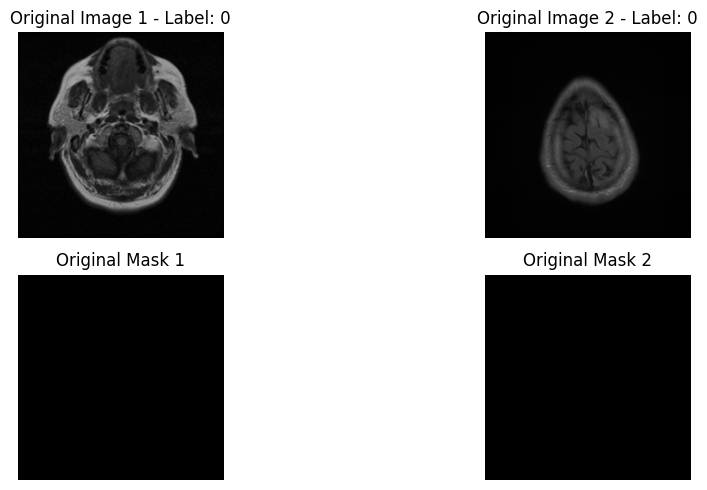

In [63]:
# Visualize a few samples (original and augmented)
plt.figure(figsize=(15, 5))
for i in range(2):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f'Original Image {i+1} - Label: {y_train[i]}')
    plt.axis('off')
    
    plt.subplot(2, 3, i + 4)
    plt.imshow(masks_train[i], cmap='gray')
    plt.title(f'Original Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

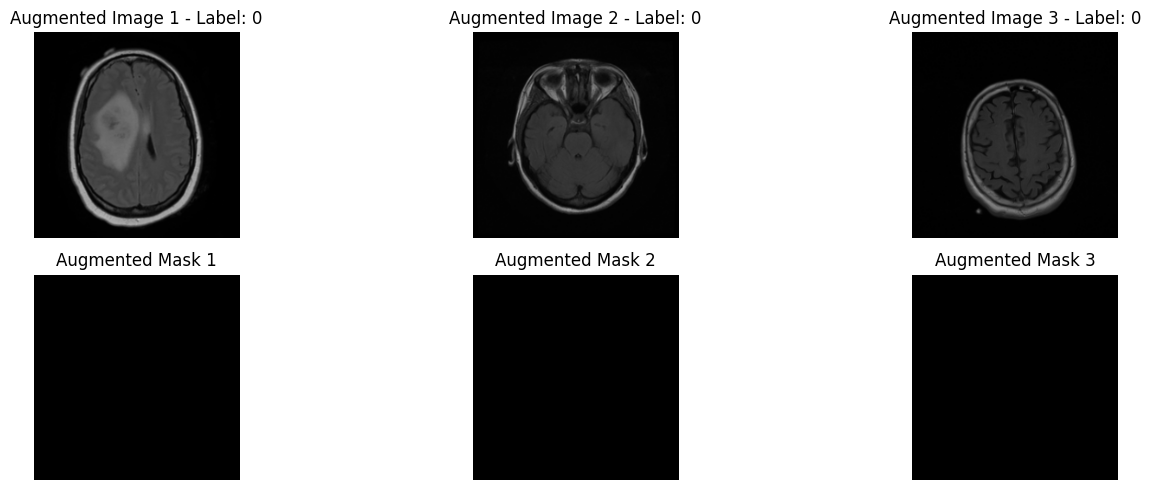

In [64]:
# Visualize a few augmented samples
plt.figure(figsize=(15, 5))
for i in range(3, 6):  # Assuming augmented data starts after original
    plt.subplot(2, 3, i - 2)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f'Augmented Image {i-2} - Label: {y_train[i]}')
    plt.axis('off')
    
    plt.subplot(2, 3, i + 1)
    plt.imshow(masks_train[i], cmap='gray')
    plt.title(f'Augmented Mask {i-2}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [65]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## MobileNetV2 Model 

In [66]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define input shape
input_shape = (224, 224, 3)

# Load pre-trained MobileNetV2 (no top layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze base layers

# Build classification model
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs, outputs)

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model Training

In [67]:
# checkpoint_cb = ModelCheckpoint("mobilenetv2_best.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
# earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# # Train
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=20,
#     callbacks=[checkpoint_cb, earlystop_cb],
#     verbose=1
# )

In [68]:
from tensorflow.keras.models import load_model

# Load the best saved model
# model = load_model("/kaggle/input/model-1/keras/default/1/mobilenetv2_best.h5")
model = load_model("mobilenetv2_best.h5")


# Confirm it's loaded
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,083 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

## Performance Analysis

In [69]:
# Evaluate the model
from tensorflow.keras.models import Model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\n Test Accuracy: {test_accuracy * 100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")


c:\Users\Maryum\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 346ms/step - accuracy: 0.7707 - loss: 0.4644

 Test Accuracy: 78.12%
 Test Loss: 0.4525


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step

Classification Report:
              precision    recall  f1-score   support

   Non-Tumor       0.83      0.84      0.83       256
       Tumor       0.69      0.68      0.68       137

    accuracy                           0.78       393
   macro avg       0.76      0.76      0.76       393
weighted avg       0.78      0.78      0.78       393



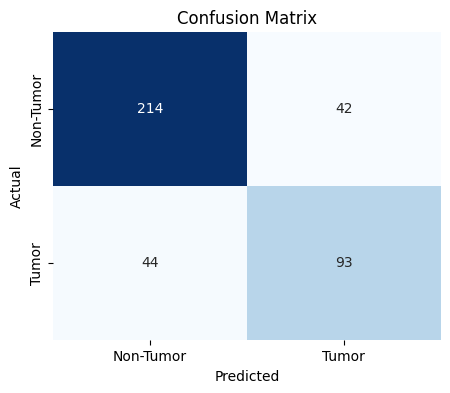

In [70]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_probs = model.predict(test_generator)
# Convert to class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = y_test  # Original labels

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Tumor", "Tumor"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar = False,  xticklabels=["Non-Tumor", "Tumor"], yticklabels=["Non-Tumor", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Visualizing Predictions

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 350ms/step


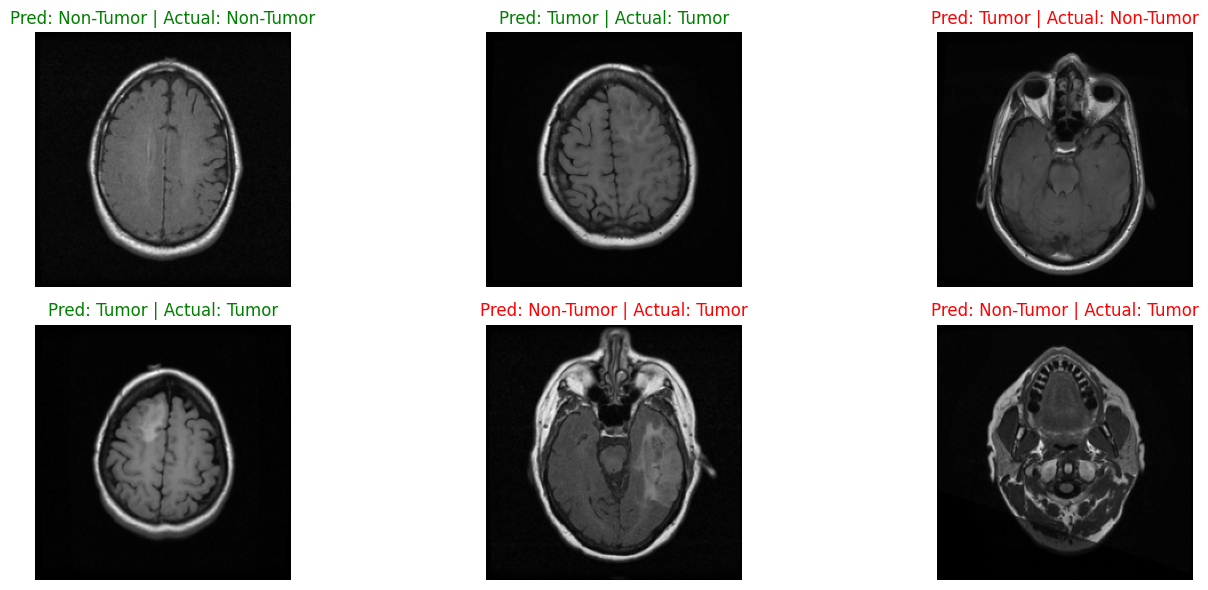

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Predict all test labels (returns probabilities)
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Original true labels
y_true = y_test

# Images used in prediction
test_images = X_test  # Already normalized and expanded to 3 channels

# Function to visualize random predictions
def show_random_predictions(n=6):
    indices = random.sample(range(len(test_images)), n)
    
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        image = test_images[idx]
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        
        title = f"Pred: {'Tumor' if pred_label == 1 else 'Non-Tumor'} | Actual: {'Tumor' if true_label == 1 else 'Non-Tumor'}"
        color = 'green' if pred_label == true_label else 'red'
        
        plt.subplot(2, (n + 1) // 2, i + 1)
        plt.imshow(image[:, :, 0], cmap='gray')  # Show one grayscale channel
        plt.title(title, color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
show_random_predictions(n=6)


In [72]:
model = load_model('mobilenetv2_best.h5')

## Segmentation

In [85]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [86]:
# Parameters
IMG_SIZE = 256

def load_data(image_paths, mask_paths):
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_files):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0  # normalize
        mask = np.expand_dims(mask / 255.0, axis=-1)  # (H, W, 1)

        images.append(img)
        masks.append(mask)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

images_np, masks_np = load_data(image_files, mask_files)


In [87]:
X_train, X_val, y_train, y_val = train_test_split(
    images_np, masks_np, test_size=0.2, random_state=42
)


In [88]:
def build_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    bn = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    bn = layers.Conv2D(128, 3, activation='relu', padding='same')(bn)

    # Decoder
    u3 = layers.UpSampling2D()(bn)
    u3 = layers.Concatenate()([u3, c3])
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(c5)

    u1 = layers.UpSampling2D()(c5)
    u1 = layers.Concatenate()([u1, c1])
    c6 = layers.Conv2D(16, 3, activation='relu', padding='same')(u1)
    c6 = layers.Conv2D(16, 3, activation='relu', padding='same')(c6)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c6)

    return models.Model(inputs, outputs)

model = build_unet((IMG_SIZE, IMG_SIZE, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_6[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 256, 256,  │      2,320 │ conv2d_30[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 128,  │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_32[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_34[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 32,    │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_36[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 64, 64,    │          0 │ conv2d_37[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 64, 64,    │          0 │ up_sampling2d_6[… │
│ (Concatenate)       │ 192)              │            │ conv2d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64,    │    110,656 │ concatenate_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_38[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 128, 128,  │          0 │ conv2d_39[0][0] 

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# Save the best model (lowest validation loss)
checkpoint = ModelCheckpoint(
    filepath='best_unet_model.keras',  #  use `.keras` format
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Stop training if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=8
)


Epoch 1/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 327s 789ms/step - accuracy: 0.9743 - loss: 0.1110 - val_accuracy: 0.9898 - val_loss: 0.0437
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 230s 585ms/step - accuracy: 0.9899 - loss: 0.0344 - val_accuracy: 0.9898 - val_loss: 0.0370
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 230s 586ms/step - accuracy: 0.9908 - loss: 0.0317 - val_accuracy: 0.9907 - val_loss: 0.0342
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 296s 673ms/step - accuracy: 0.9915 - loss: 0.0314 - val_accuracy: 0.9903 - val_loss: 0.0346
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 282s 717ms/step - accuracy: 0.9916 - loss: 0.0299 - val_accuracy: 0.9911 - val_loss: 0.0318
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 227s 578ms/step - accuracy: 0.9915 - loss: 0.0299 - val_accuracy: 0.9906 - val_loss: 0.0341
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 223s 569ms/step - accuracy: 0.9915 - loss: 0.0297 - val_accuracy: 0.9909 - val_loss: 0.0329
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 228s 580ms/step - accuracy: 0.9919 -

In [ ]:
model.save('best_segmentation_model.h5')  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


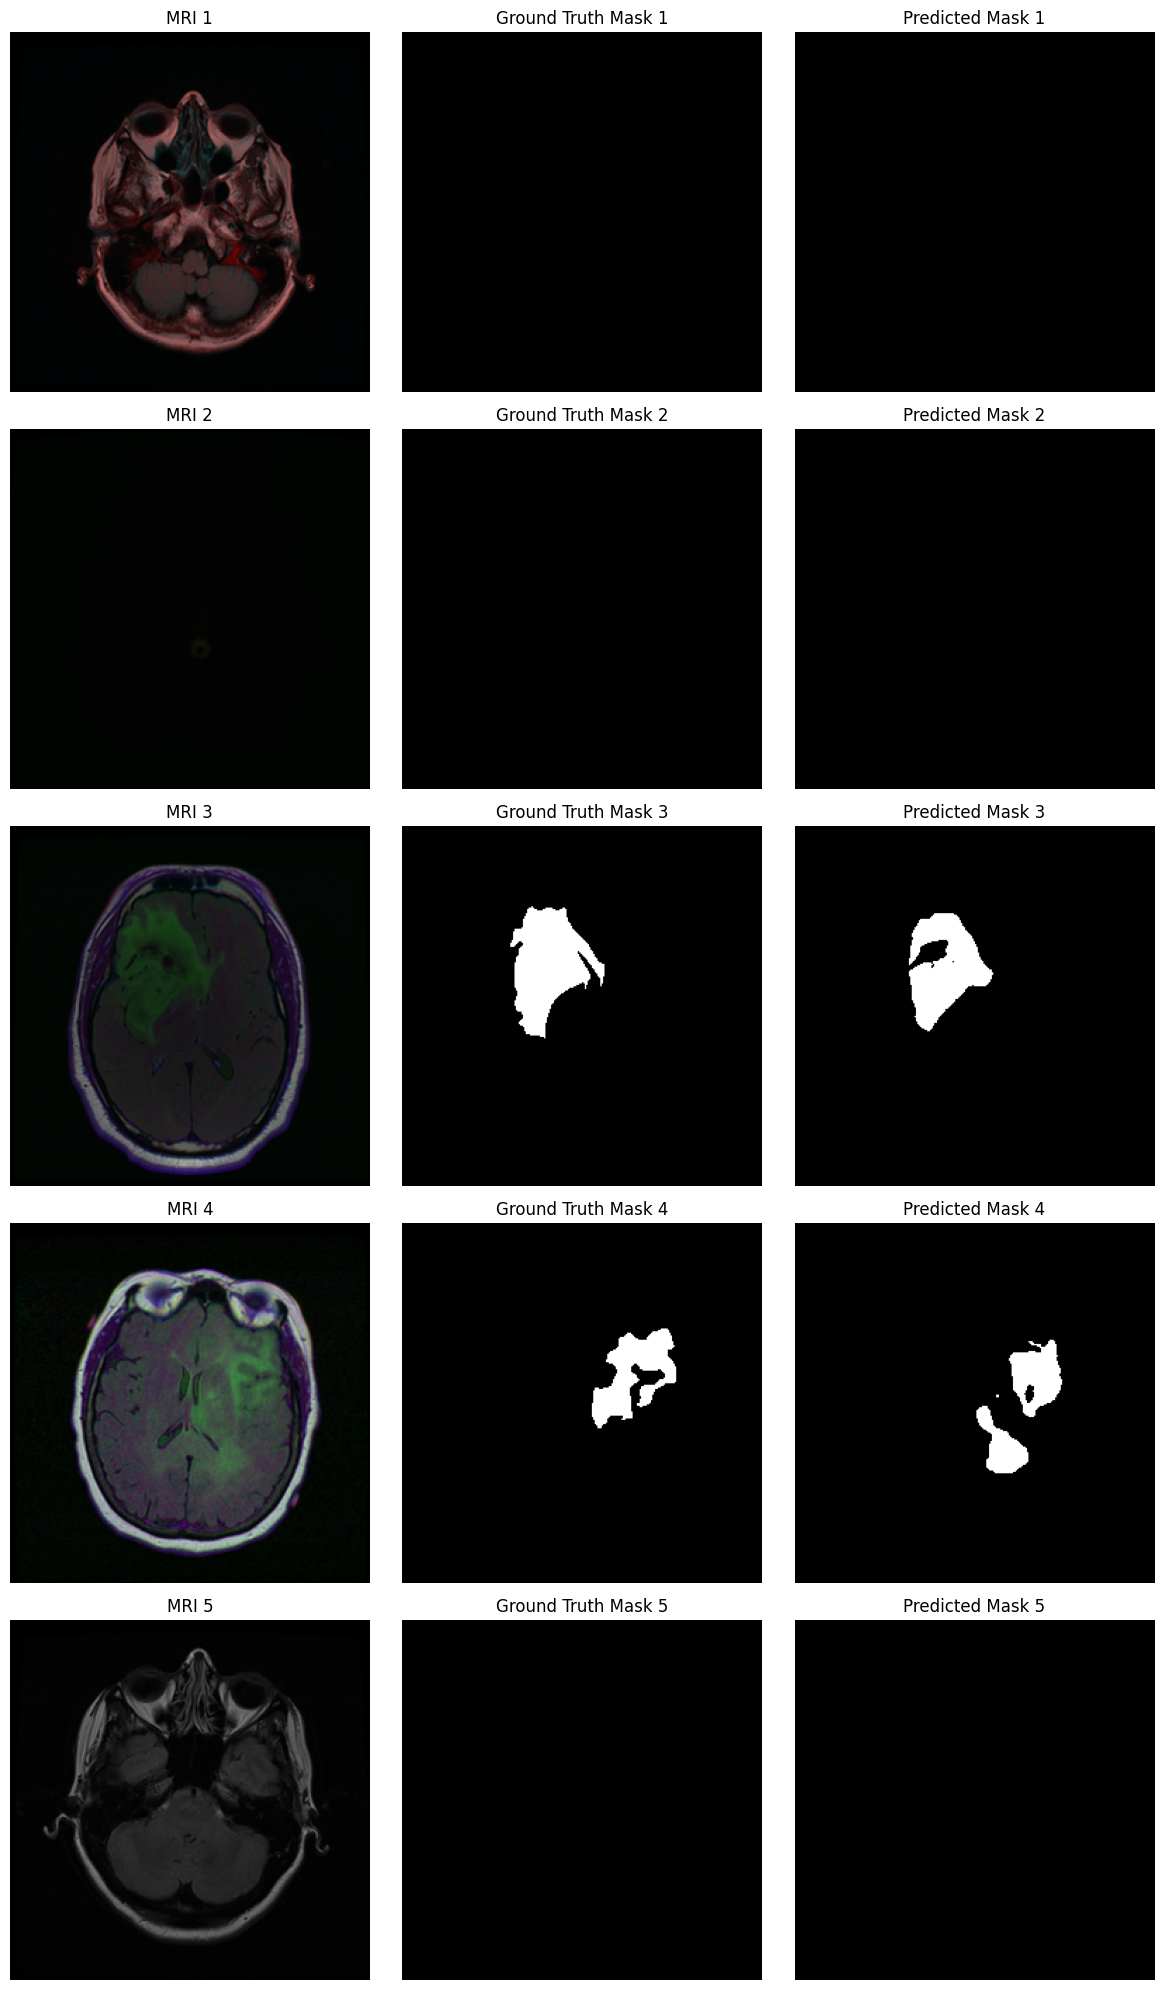

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples to display
num_samples = 5  # Adjust this to show more or fewer results

plt.figure(figsize=(12, 4 * num_samples))  # Adjust figure size based on number of samples

for i in range(num_samples):
    # Get sample image and predict
    sample_img = X_val[i]
    pred = model.predict(np.expand_dims(sample_img, axis=0))[0, ..., 0]
    
    # Threshold prediction
    pred_mask = (pred > 0.5).astype(np.uint8)
    
    # Plot MRI
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.title(f"MRI {i+1}")
    plt.imshow(sample_img)
    plt.axis('off')  # Optional: hide axes for cleaner visuals
    
    # Plot Ground Truth Mask
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.title(f"Ground Truth Mask {i+1}")
    plt.imshow(y_val[i].squeeze(), cmap='gray')
    plt.axis('off')
    
    # Plot Predicted Mask
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.title(f"Predicted Mask {i+1}")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

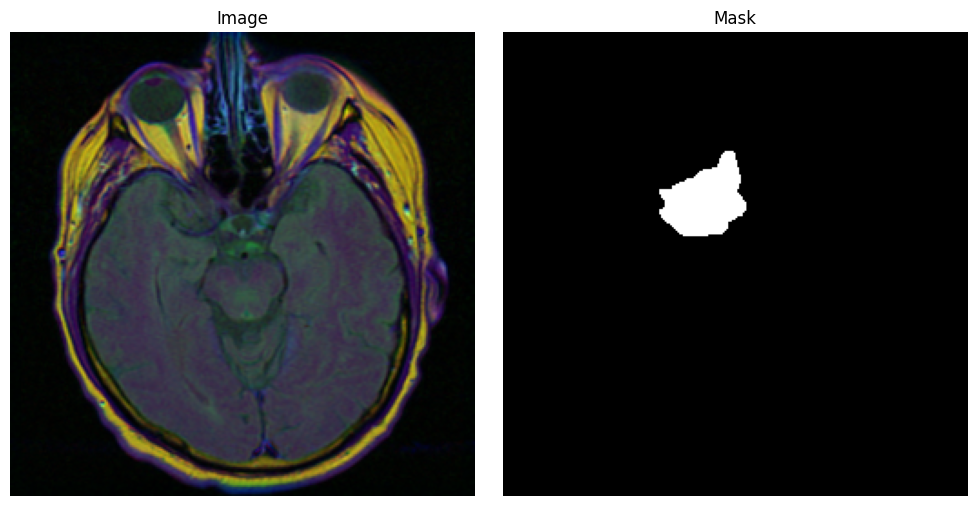

In [81]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread(image_files[1])
mask = cv2.imread(mask_files[1])

# Convert BGR to RGB for displaying correctly in matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Image")
plt.axis('off')

# Show mask
plt.subplot(1, 2, 2)
plt.imshow(mask_rgb)
plt.title("Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


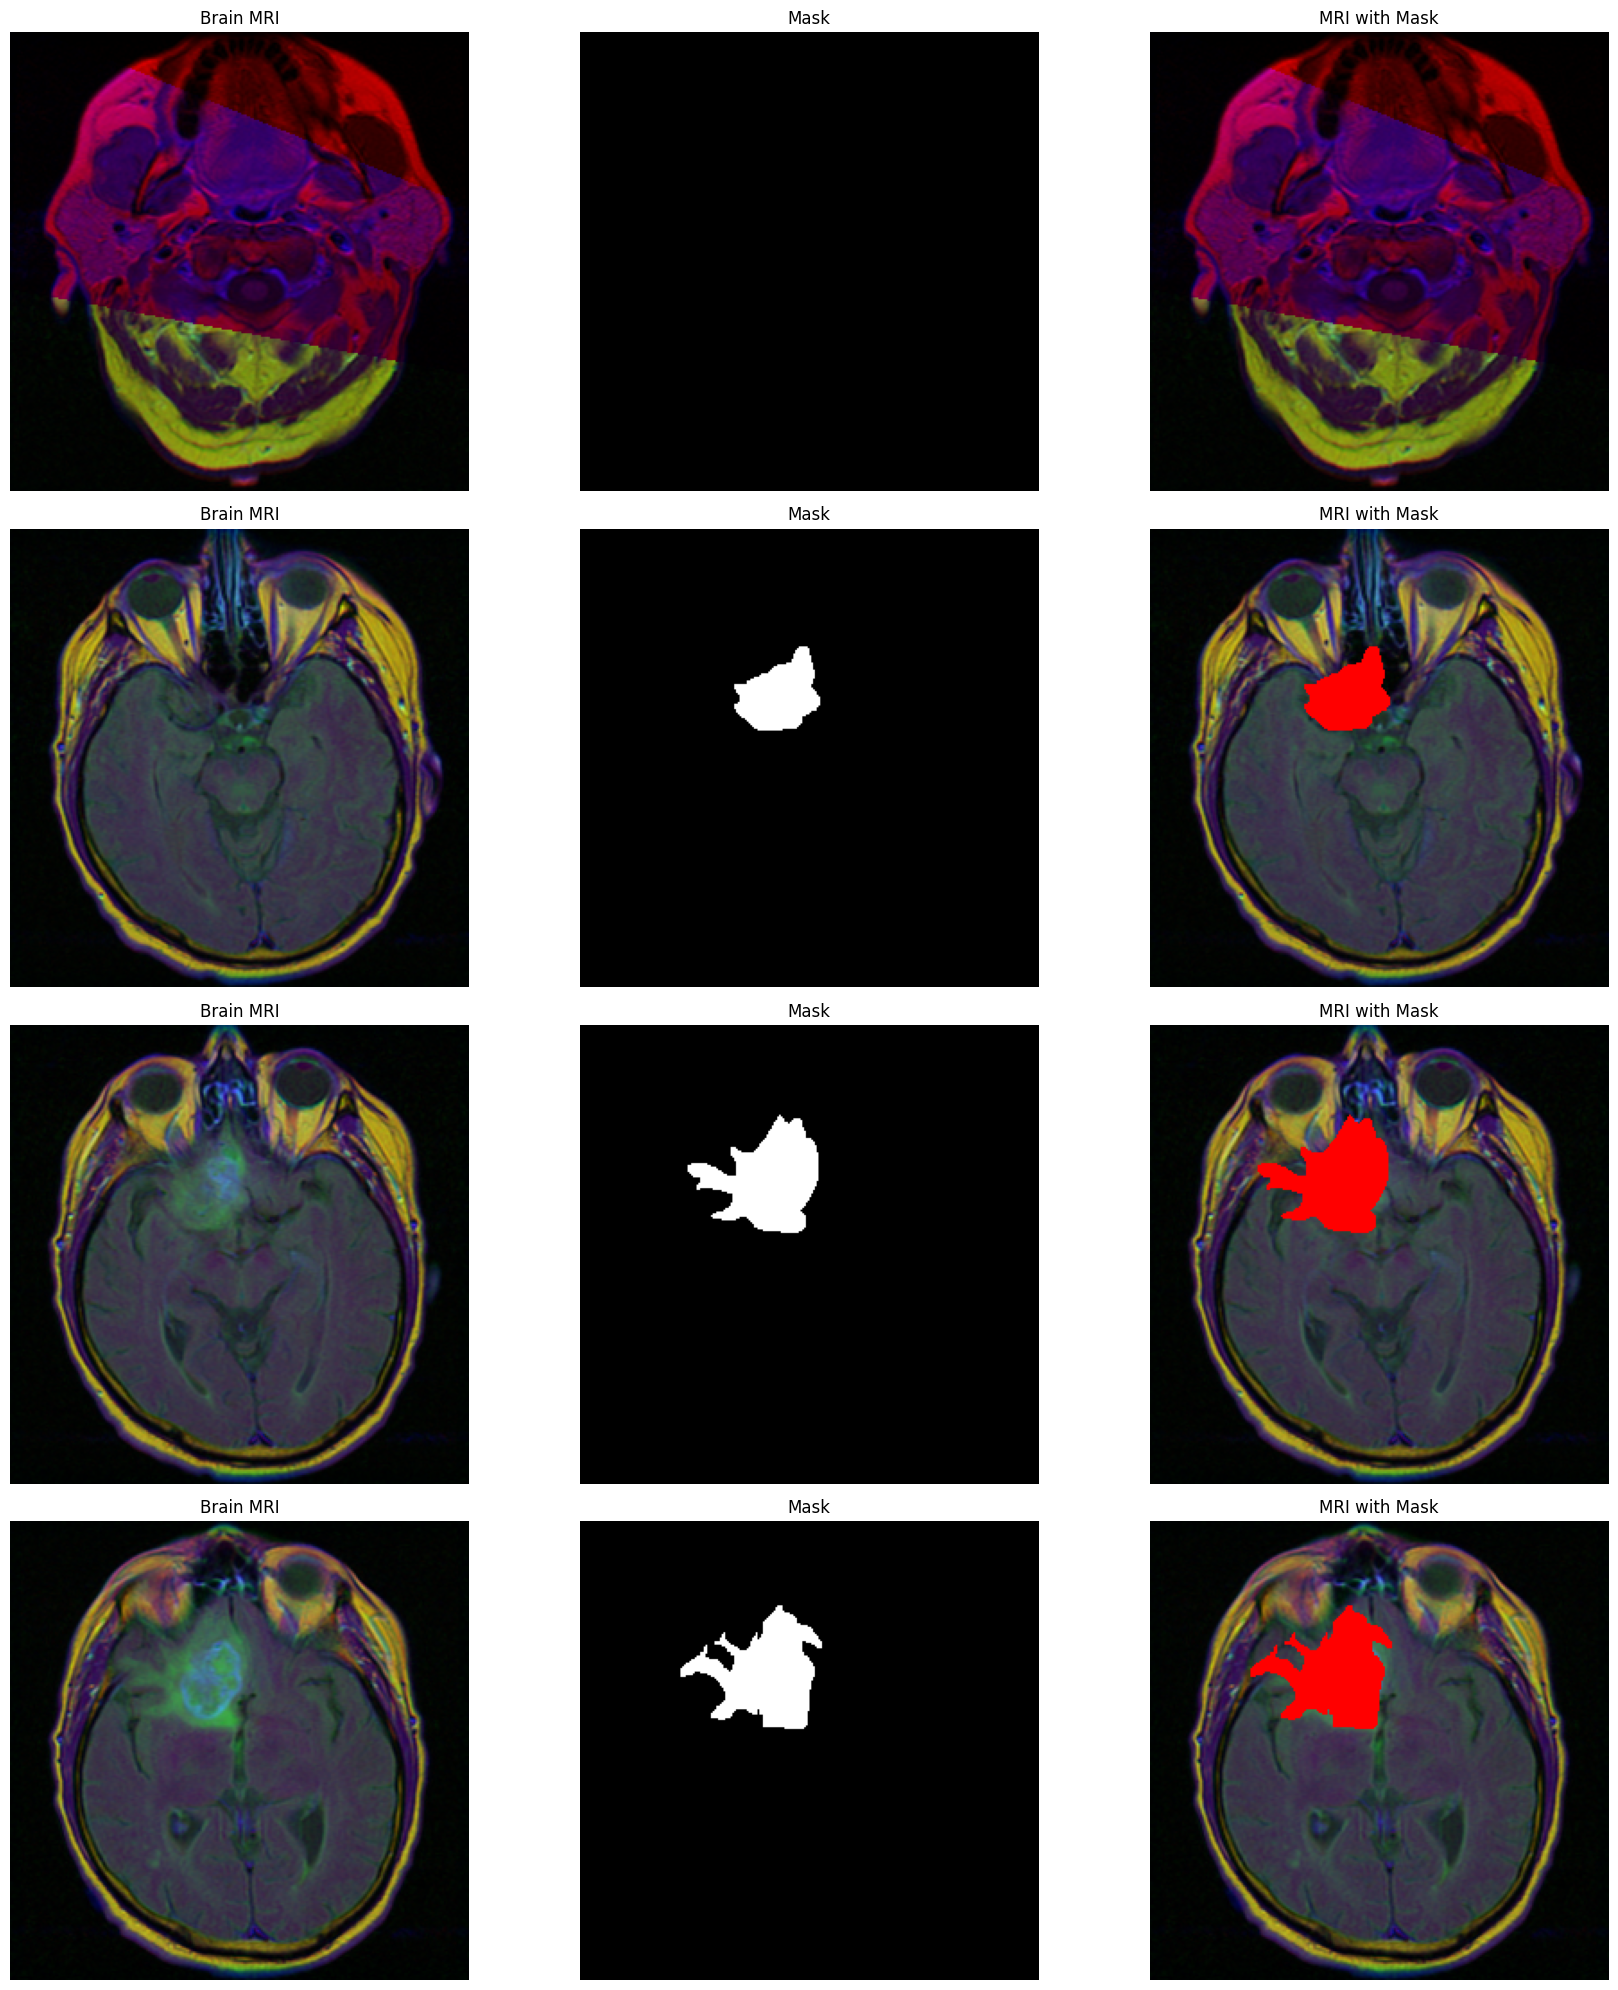

In [91]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

fig, axs = plt.subplots(4, 3, figsize=(18, 20))
count = 0

for i in range(len(image_files)):
    if count >= 4:
        break

    img = cv2.imread(image_files[i])
    mask = cv2.imread(mask_files[i], cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        continue

    img = cv2.resize(img, (mask.shape[1], mask.shape[0]))  # Make sure sizes match
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Overlay mask in red
    overlay = img.copy()
    overlay[mask == 255] = [255, 0, 0]  # Apply red color where mask is present

    # Plot original MRI
    axs[count, 0].imshow(img)
    axs[count, 0].set_title("Brain MRI")
    axs[count, 0].axis('off')

    # Plot mask
    axs[count, 1].imshow(mask, cmap='gray')
    axs[count, 1].set_title("Mask")
    axs[count, 1].axis('off')

    # Plot MRI with red overlay
    axs[count, 2].imshow(overlay)
    axs[count, 2].set_title("MRI with Mask")
    axs[count, 2].axis('off')

    count += 1

plt.tight_layout()
plt.show()
